# Lecture 6 Worksheet

## Part 1: Data Types, Graphical Marks, and Visual Encoding Channels

A visualization represents data using a collection of _graphical marks_ (bars, lines, points, etc.). The attributes of a mark &mdash; such as its position, shape, size, or color &mdash; serve as _channels_ through which we can encode underlying data values.

> With a basic framework of _data types_, _marks_, and _encoding channels_, we can concisely create a wide variety of visualizations. In this notebook, we explore each of these elements and show how to use them to create custom statistical graphics.
> 
>_This notebook is part of the [data visualization curriculum](https://github.com/uwdata/visualization-curriculum) at the University of Washington. This notebook series was developed by Jeffrey Heer, Dominik Moritz, Jake VanderPlas, and Brock Craft. Thanks to the UW Interactive Data Lab and Arvind Satyanarayan for their valuable input and feedback! Thanks also to the students of UW CSE512 Spring 2019, the first group to use these notebooks within an integrated course curriculum._

> Copyright (c) 2019, University of Washington
All rights reserved.


**At UBC, I adapted these notebooks and added some additional commentary for students in DSCI 531 as part of the lecture worksheets.**

In [79]:
import pandas as pd
import numpy as np
import altair as alt

import vega_datasets

# use this line if you are in a Jupyter Notebook (not JupyterLab) environment
# alt.renderers.enable('notebook')

# You need to enable json to allow you to work with larger datasets without your notebooks becoming huge
# See Here for details (https://altair-viz.github.io/user_guide/faq.html).
# If you have trouble with blank charts, try commenting this next line out

alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## Themes in Altair (under development)

Theme from [this article](https://towardsdatascience.com/consistently-beautiful-visualizations-with-altair-themes-c7f9f889602) that goes into detail about how to create themes and provides an example that I adapted for us:



In [76]:
def mds_special():
    font = "Arial"
    axisColor = "#000000"
    gridColor = "#DEDDDD"
    return {
        "config": {
            "title": {
                "fontSize": 24,
                "font": font,
                "anchor": "start", # equivalent of left-aligned.
                "fontColor": "#000000"
            },
            "axisX": {
                "domain": True,
                #"domainColor": axisColor,
                "gridColor": gridColor,
                "domainWidth": 1,
                "grid": False,
                "labelFont": font,
                "labelFontSize": 12,
                "labelAngle": 0, 
                #"tickColor": axisColor,
                "tickSize": 5, # default, including it just to show you can change it
                #"titleFont": font,
                "titleFontSize": 18,
                "titlePadding": 10, # guessing, not specified in styleguide
                "title": "X Axis Title (units)", 
            },
            "axisY": {
                "domain": False,
                "grid": True,
                "gridColor": gridColor,
                "gridWidth": 1,
                "labelFont": font,
                "labelFontSize": 12,
                "labelAngle": 0, 
                #"ticks": False, # even if you don't have a "domain" you need to turn these off.
                "titleFont": font,
                "titleFontSize": 18,
                "titlePadding": 10, # guessing, not specified in styleguide
                "title": "Y Axis Title (units)", 
                # titles are by default vertical left of axis so we need to hack this 
                #"titleAngle": 0, # horizontal
                #"titleY": -10, # move it up
                #"titleX": 18, # move it to the right so it aligns with the labels 
            },
                }
            }

In [77]:
# Now we need to register the custom theme 

# register the custom theme under a chosen name
alt.themes.register('mds_special', mds_special)

# enable the newly registered theme
alt.themes.enable('mds_special')
#alt.themes.enable('none') # to return to default

ThemeRegistry.enable('mds_special')

## Global Development Data (the gapminder dataset returns!)

We will be visualizing global health and population data for a number of countries, over the time period of 1955 to 2005. The data was collected by the [Gapminder Foundation](https://www.gapminder.org/) and shared in [Hans Rosling's popular TED talk](https://www.youtube.com/watch?v=hVimVzgtD6w). If you haven't seen the talk, we encourage you to watch it first!

Let's first load the dataset from the [vega-datasets](https://github.com/vega/vega-datasets) collection into a Pandas data frame.

Note that while you're still learning wrangling in DSCI 523, I hope that these annotated features of the dataframe are helpful in developing your skills to explore data analysis.

In [63]:
from vega_datasets import data as vega_data
data = pd.read_json(vega_data.gapminder.url)

In [64]:
data.head()

,year,country,cluster,pop,life_expect,fertility
0,1955,Afghanistan,0,8891209,30.332,7.7
1,1960,Afghanistan,0,9829450,31.997,7.7
2,1965,Afghanistan,0,10997885,34.020,7.7
3,1970,Afghanistan,0,12430623,36.088,7.7
4,1975,Afghanistan,0,14132019,38.438,7.7


Let's check how big the data is

In [65]:
data.shape

(693, 6)

693 rows and 6 columns! Let's take a peek at the data content:

In [66]:
data.head() # recall that head prints out the first 5 rows of the dataframe

,year,country,cluster,pop,life_expect,fertility
0,1955,Afghanistan,0,8891209,30.332,7.7
1,1960,Afghanistan,0,9829450,31.997,7.7
2,1965,Afghanistan,0,10997885,34.020,7.7
3,1970,Afghanistan,0,12430623,36.088,7.7
4,1975,Afghanistan,0,14132019,38.438,7.7


For each `country` and `year` (in 5-year intervals), we have measures of fertility in terms of the number of children per woman (`fertility`), life expectancy in years (`life_expect`), and total population (`pop`).

We also see a `cluster` field with an integer code. What might this represent? We'll try and solve this mystery as we visualize the data!

Let's also create a smaller data frame, filtered down to values for the year 2000 only:

In [67]:
data2000 = data.loc[data['year'] == 2000] 

# That was the .loc syntax Tom talked about in lecture 5

In [68]:
data2000.head(5)

,year,country,cluster,pop,life_expect,fertility
9,2000,Afghanistan,0,23898198,42.129,7.4792
20,2000,Argentina,3,37497728,74.340,2.3500
31,2000,Aruba,3,69539,73.451,2.1240
42,2000,Australia,4,19164620,80.370,1.7560
53,2000,Austria,1,8113413,78.980,1.3820


## Data Types

**We saw these data types already in Lecture 5, but it is worth repeating that you should ALWAYS specify your datatypes in Altair. If you don't, you risk Altair guessing it incorrectly**

The first ingredient in effective visualization is the input data. Data values can represent different forms of measurement. What kinds of comparisons do those measurements support? And what kinds of visual encodings then support those comparisons?

We will start by looking at the basic data types that Altair uses to inform visual encoding choices. These data types determine the kinds of comparisons we can make, and thereby guide our visualization design decisions.

### Nominal (N)

*Nominal* data (also called *categorical* data) consist of category names. 

With nominal data we can compare the equality of values: *is value A the same or different than value B? (A = B)*, supporting statements like “A is equal to B” or “A is not equal to B”.
In the dataset above, the `country` field is nominal.

When visualizing nominal data we should readily be able to see if values are the same or different: position, color hue (blue, red, green, *etc.*), and shape can help. However, using a size channel to encode nominal data might mislead us, suggesting rank-order or magnitude differences among values that do not exist!

### Ordinal (O)

*Ordinal* data consist of values that have a specific ordering.

With ordinal data we can compare the rank-ordering of values: *does value A come before or after value B? (A < B)*, supporting statements like “A is less than B” or “A is greater than B”.
In the dataset above, we can treat the `year` field as ordinal.

When visualizing ordinal data, we should perceive a sense of rank-order. Position, size, or color value (brightness) might be appropriate, where as color hue (which is not perceptually ordered) would be less appropriate.

### Quantitative (Q)

With *quantitative* data we can measure numerical differences among values. There are multiple sub-types of quantitative data:

For *interval* data we can measure the distance (interval) between points: *what is the distance to value A from value B? (A - B)*, supporting statements such as “A is 12 units away from B”.

For *ratio* data the zero-point is meaningful and so we can also measure proportions or scale factors: *value A is what proportion of value B? (A / B)*, supporting statements such as “A is 10% of B” or “B is 7 times larger than A”.

In the dataset above, `year` is a quantitative interval field (the value of year "zero" is subjective), whereas `fertility` and `life_expect` are quantitative ratio fields (zero is meaningful for calculating proportions).
Vega-Lite represents quantitative data, but does not make a distinction between interval and ratio types.

Quantitative values can be visualized using position, size, or color value, among other channels. An axis with a zero baseline is essential for proportional comparisons of ratio values, but can be safely omitted for interval comparisons.

### Temporal (T)

*Temporal* values measure time points or intervals. This type is a special case of quantitative values (timestamps) with rich semantics and conventions (i.e., the [Gregorian calendar](https://en.wikipedia.org/wiki/Gregorian_calendar)). The temporal type in Vega-Lite supports reasoning about time units (year, month, day, hour, etc.), and provides methods for requesting specific time intervals.

Example temporal values include date strings such as `“2019-01-04”` and `“Jan 04 2019”`, as well as standardized date-times such as the [ISO date-time format](https://en.wikipedia.org/wiki/ISO_8601): `“2019-01-04T17:50:35.643Z”`.

There are no temporal values in our global development dataset above, as the `year` field is simply encoded as an integer. For more details about using temporal data in Altair, see the [Times and Dates documentation](https://altair-viz.github.io/user_guide/times_and_dates.html).

### Summary

These data types are not mutually exclusive, but rather form a hierarchy: ordinal data support nominal (equality) comparisons, while quantitative data support ordinal (rank-order) comparisons.

Moreover, these data types do _not_ provide a fixed categorization. Just because a data field is represented using a number doesn't mean we have to treat it as a quantitative type! For example, we might interpret a set of ages (10 years old, 20 years old, etc) as nominal (underage or overage), ordinal (grouped by year), or quantitative (calculate average age).

Now let's examine how to visually encode these data types!


## Encoding Channels

At the heart of Altair is the use of *encodings* that bind data fields (with a given data type) to available encoding *channels* of a chosen *mark* type. In this notebook we'll examine the following encoding channels:

- `x`: Horizontal (x-axis) position of the mark.
- `y`: Vertical (y-axis) position of the mark.
- `size`: Size of the mark. May correspond to area or length, depending on the mark type.
- `color`: Mark color, specified as a [legal CSS color](https://developer.mozilla.org/en-US/docs/Web/CSS/color_value).
- `opacity`: Mark opacity, ranging from 0 (fully transparent) to 1 (fully opaque).
- `shape`: Plotting symbol shape for `point` marks.
- `tooltip`: Tooltip text to display upon mouse hover over the mark.
- `order`: Mark ordering, determines line/area point order and drawing order.
- `column`: Facet the data into horizontally-aligned subplots.
- `row`: Facet the data into vertically-aligned subplots.

For a complete list of available channels, see the [Altair encoding documentation](https://altair-viz.github.io/user_guide/encoding.html).

### X - Encoding Channel

The `x` encoding channel sets a mark's horizontal position (x-coordinate). In addition, default choices of axis and title are made automatically. In the chart below, the choice of a quantitative data type results in a continuous linear axis scale:

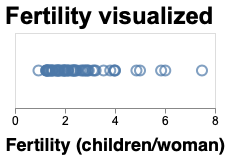

In [69]:
alt.Chart(data2000).mark_point(size=100).encode(
    alt.X('fertility:Q', title='Fertility (children/woman)')
).properties(height=75, title="Fertility visualized")

#### WQ01: What happens when you change the datatype of fertility in the example above? Try: Nominal, Temporal, Ordinal

> Your answers here:
>
> - Nominal: 
> 
> - Temporal: 
> 
> - Ordinal: 

#### WQ02: Try to make the point marks larger, use the `size` parameter for mark_point()

> Your answer here (Where did you put the size parameter? How large did you make it?)

### Y - Encoding Channel

The `y` encoding channel sets a mark's vertical position (y-coordinate). Here we've added the `cluster` field using an ordinal (`O`) data type. The result is a discrete axis that includes a sized band, with a default step size, for each unique value:

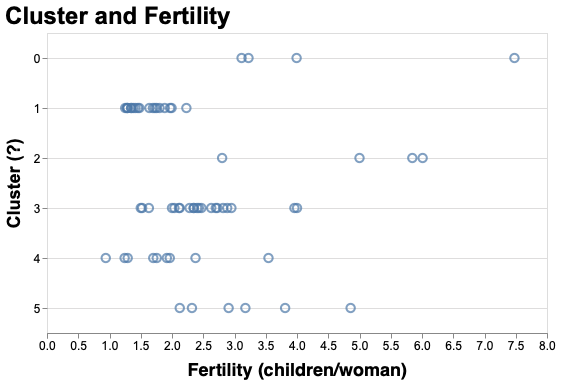

In [70]:
alt.Chart(data2000).mark_point(size=70).encode(
    alt.X('fertility:Q', title='Fertility (children/woman)'),
    alt.Y('cluster:O', title="Cluster (?)")
).properties(title='Cluster and Fertility',height=300,width=500)

# to change the ordering on the y-axis, add: scale=alt.Scale(domain=["5","4","3","2","1","0"])

_What happens to the chart above if you swap the `O` and `Q` field types?_

If we instead add the `life_expect` field as a quantitative (`Q`) variable, the result is a scatter plot with linear scales for both axes:

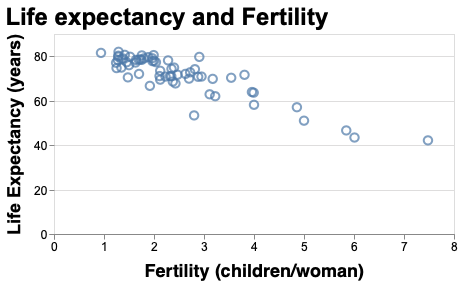

In [73]:
alt.Chart(data2000).mark_point(size=70).encode(
    alt.X('fertility:Q', title='Fertility (children/woman)'),
    alt.Y('life_expect:Q', title='Life Expectancy (years)')
).properties(title='Life expectancy and Fertility', width=400)

By default, axes for linear quantitative scales include zero to ensure a proper baseline for comparing ratio-valued data. In some cases, however, a zero baseline may be meaningless or you may want to focus on interval comparisons. To disable automatic inclusion of zero, configure the scale mapping using the encoding `scale` attribute:

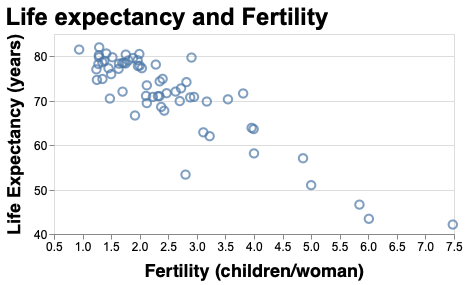

In [74]:
alt.Chart(data2000).mark_point(size=70).encode(
    alt.X('fertility:Q', scale=alt.Scale(zero=False, nice=True), title="Fertility (children/woman)"),
    alt.Y('life_expect:Q', scale=alt.Scale(zero=False), title="Life Expectancy (years)")
).properties(title='Life expectancy and Fertility', width=400)

Now the axis scales no longer include zero by default.

#### WQ03: What happens if you also add `nice=False` to one or both of the scale attribute above?

> Your answer here

Some padding still remains, as the axis domain end points are automatically snapped to _nice_ numbers like multiples of 5 or 10.

## Part 2: A Case Study - Bullet holes in surviving planes from World War 2

In [23]:
import pandas as pd
# You can download the bullet_data csv file from the 531 student repo:
# https://github.ubc.ca/MDS-2019-20/DSCI_531_viz-1_students/tree/master/participation
# Add this csv file to your participation, then read it in
bullet_data = pd.read_csv('bullet_data.csv')

bullet_data.head()

print("The zones are: {0}".format(sorted(set(bullet_data['zone']))),"\n")

print("Columns are: {0}".format(list(bullet_data.columns)),"\n")

print("Values for 'bullet' column is either 1 or NA","\n")

The zones are: ['A', 'B', 'C', 'D', 'E', 'OutsidePlane', 'Unknown'] 

Columns are: ['x', 'y', 'bullet', 'zone'] 

Values for 'bullet' column is either 1 or NA 



In [24]:
# Let's wrangle the data a bit to try and see what's going on:

# First, only consider the bullet 'hits':

hits_df = bullet_data[bullet_data['bullet']==1]
hits_df.head()

# Then, let's groupby the "zone" and look at the resulting dataframe
# I have "reset" the index of the groupby object so we can plot it with Altair
# You'll learn more about this in DSCI 523 (Wrangling)

summary = hits_df.groupby('zone').count().reset_index()
summary

,zone,x,y,bullet
0,A,83,83,83
1,B,259,259,259
2,C,83,83,83
3,D,47,47,47
4,E,111,111,111
5,Unknown,16,16,16


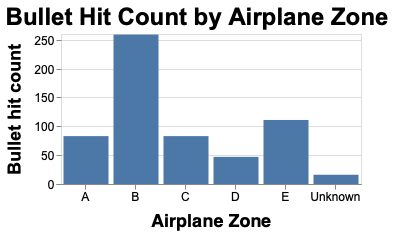

In [25]:
# That's a pretty succinct table that shows us where all the hits are
# Let's plot it:

alt.Chart(summary).encode(alt.X("zone", title="Airplane Zone"),
                          alt.Y("bullet", title="Bullet hit count")
                         ).mark_bar(
                         ).configure_axisX(labelAngle=0
).properties(width=300, height=150, 
             title="Bullet Hit Count by Airplane Zone")

#### WQ04: If you could reinforce two zones, which would you pick?
> Your answer here

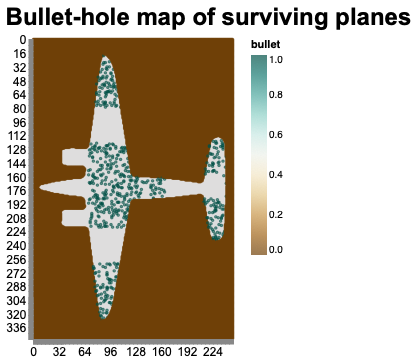

In [26]:
# Let's visualize the bullet holes on top of the outline of a plane

bullets = alt.Chart(bullet_data).mark_point(color='red',size=2).encode(
    alt.X("x:O"),
    alt.Y("y:O"),
    alt.Color("bullet:Q",scale=alt.Scale(scheme='brownbluegreen'))
).properties(width=200,height=300, title= "Bullet-hole map of surviving planes")

bullets

## Part 3: Graphical Marks

Our exploration of encoding channels above exclusively uses `point` marks to visualize the data. However, the `point` mark type is only one of the many geometric shapes that can be used to visually represent data. Altair includes a number of built-in mark types, including:

- `mark_area()` - Filled areas defined by a top-line and a baseline.
- `mark_bar()` -	Rectangular bars.
- `mark_circle()`	- Scatter plot points as filled circles.
- `mark_line()` - Connected line segments.
- `mark_point()` - Scatter plot points with configurable shapes.
- `mark_rect()` - Filled rectangles, useful for heatmaps.
- `mark_rule()` - Vertical or horizontal lines spanning the axis.
- `mark_square()` - Scatter plot points as filled squares.
- `mark_text()` - Scatter plot points represented by text.
- `mark_tick()` - Vertical or horizontal tick marks.	

For a complete list, and links to examples, see the [Altair marks documentation](https://altair-viz.github.io/user_guide/marks.html). Next, we will step through a number of the most commonly used mark types for statistical graphics.

## Part 3: Diving deeper into Altair 

### Firas' note about the "Size" and "Color and Opacity" sections: 

> I still maintain that bubble charts are not effective visualizations at all! But it is worth seeing how they work to dig deeper into the Altair syntax with this dataset. 
> 
> Also, I have moved the "Shapes" section of this to the "Appendix" for your reference if you ever need to know how to change marker shapes.

### Size

The `size` encoding channel sets a mark's size or extent. The meaning of the channel can vary based on the mark type. For `point` marks, the `size` channel maps to the pixel area of the plotting symbol, such that the diameter of the point matches the square root of the size value.

Let's augment our scatter plot by encoding population (`pop`) on the `size` channel. As a result, the chart now also includes a legend for interpreting the size values.

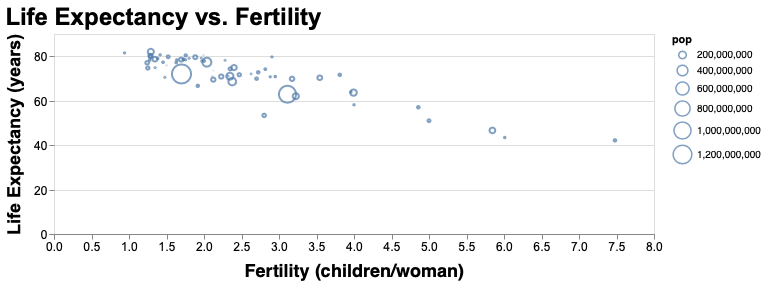

In [27]:
alt.Chart(data2000).mark_point().encode(
    alt.X('fertility:Q', title="Fertility (children/woman)"),
    alt.Y('life_expect:Q',title="Life Expectancy (years)"),
    alt.Size('pop:Q')
).properties(title = "Life Expectancy vs. Fertility",width=600)

In some cases we might be unsatisfied with the default size range. To provide a customized span of sizes, set the `range` parameter of the `scale` attribute to an array indicating the smallest and largest sizes. Here we update the size encoding to range from 0 pixels (for zero values) to 1,000 pixels (for the maximum value in the scale domain):

### Color and Opacity

The `color` encoding channel sets a mark's color. The style of color encoding is highly dependent on the data type: nominal data will default to a multi-hued qualitative color scheme, whereas ordinal and quantitative data will use perceptually ordered color gradients.

Here, we encode the `cluster` field using the `color` channel and a nominal (`N`) data type, resulting in a distinct hue for each cluster value. Can you start to guess what the `cluster` field might indicate?


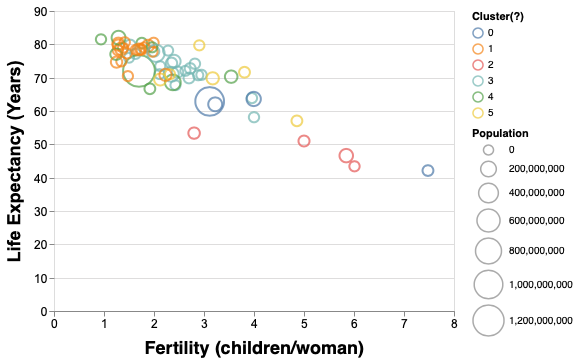

In [28]:
alt.Chart(data2000).mark_point().encode(
    alt.X('fertility:Q', title="Fertility (children/woman)"),
    alt.Y('life_expect:Q',title="Life Expectancy (Years)"),
    alt.Size('pop:Q', scale=alt.Scale(range=[100,1000]), title="Population"),
    alt.Color('cluster:N',title="Cluster(?)")
).properties(width=400,height=300)

If we prefer filled shapes, we can can pass a `filled=True` parameter to the `mark_point` method. Let's also make those circles larger!

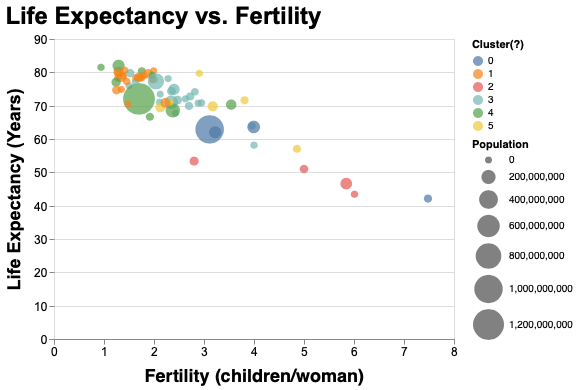

In [29]:
alt.Chart(data2000).mark_point(filled=True).encode(
    alt.X('fertility:Q', title="Fertility (children/woman)"),
    alt.Y('life_expect:Q',title="Life Expectancy (Years)"),
    alt.Size('pop:Q', scale=alt.Scale(range=[50,1000]), title="Population"),
    alt.Color('cluster:N',title="Cluster(?)")
).properties(width=400,height=300,title = "Life Expectancy vs. Fertility")

By default, Altair uses a bit of transparency to help combat over-plotting. We are free to further adjust the opacity, either by passing a default value to the `mark_*` method, or using a dedicated encoding channel.

Here we demonstrate how to provide a constant value to an encoding channel instead of binding a data field:

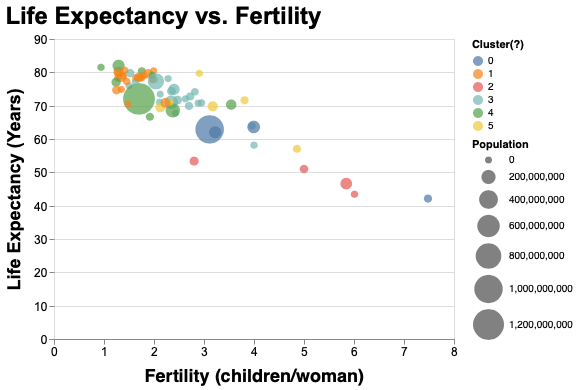

In [30]:
chart1 = alt.Chart(data2000).mark_point(filled=True).encode(
            alt.X('fertility:Q', title="Fertility (children/woman)"),
            alt.Y('life_expect:Q',title="Life Expectancy (Years)"),
            alt.Size('pop:Q', scale=alt.Scale(range=[50,1000]), title="Population"),
            alt.Color('cluster:N',title="Cluster(?)"),
            alt.Opacity(value = 0.7)
        ).properties(width=400,height=300,title = "Life Expectancy vs. Fertility")
chart1

### Tooltips & Ordering

By this point, you might feel a bit frustrated: we've built up a chart, but we still don't know what countries the visualized points correspond to! Let's add interactive tooltips to enable exploration.

The `tooltip` encoding channel determines tooltip text to show when a user moves the mouse cursor over a mark. Let's add a tooltip encoding for the `country` field, then investigate which countries are being represented.


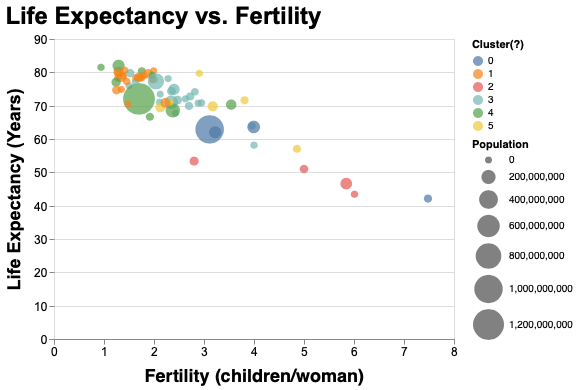

In [31]:
alt.Chart(data2000).mark_point(filled=True).encode(
    alt.X('fertility:Q', title="Fertility (children/woman)"),
    alt.Y('life_expect:Q',title="Life Expectancy (Years)"),
    alt.Size('pop:Q', scale=alt.Scale(range=[50,1000]), title="Population"),
    alt.Color('cluster:N',title="Cluster(?)"),
    alt.Tooltip(['country','fertility','pop'])
).properties(width=400,height=300,title = "Life Expectancy vs. Fertility")


As you mouse around you may notice that you can not select some of the points. For example, the largest dark blue circle corresponds to India, which is drawn on top of a country with a smaller population, preventing the mouse from hovering over that country. To fix this problem, we can use the `order` encoding channel.

The `order` encoding channel determines the order of data points, affecting both the order in which they are drawn and, for `line` and `area` marks, the order in which they are connected to one another.

Let's order the values in descending rank order by the population (`pop`), ensuring that smaller circles are drawn later than larger circles:

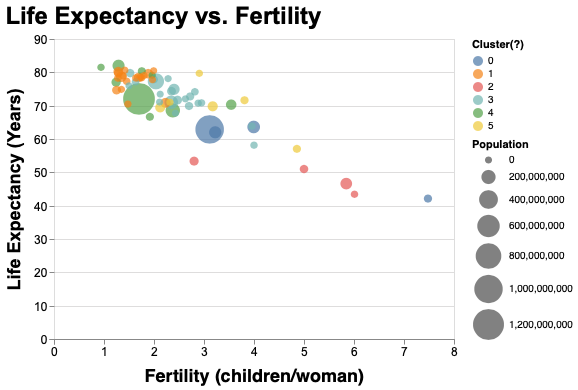

In [32]:
alt.Chart(data2000).mark_point(filled=True).encode(
    alt.X('fertility:Q', title="Fertility (children/woman)"),
    alt.Y('life_expect:Q',title="Life Expectancy (Years)"),
    alt.Size('pop:Q', scale=alt.Scale(range=[50,1000]), title="Population"),
    alt.Color('cluster:N',title="Cluster(?)"),
    alt.Tooltip(['country','fertility']), #shorthand way
    alt.Order('pop:Q', sort='descending') # important
).properties(width=400,height=300,title = "Life Expectancy vs. Fertility")

Now we can identify the smaller country being obscured by India: it's Bangladesh!

We can also now figure out what the `cluster` field represents. Mouse over the various colored points to formulate your own explanation.

At this point we've added tooltips that show only a single property of the underlying data record. To show multiple values, we can provide the `tooltip` channel an array of encodings, one for each field we want to include:

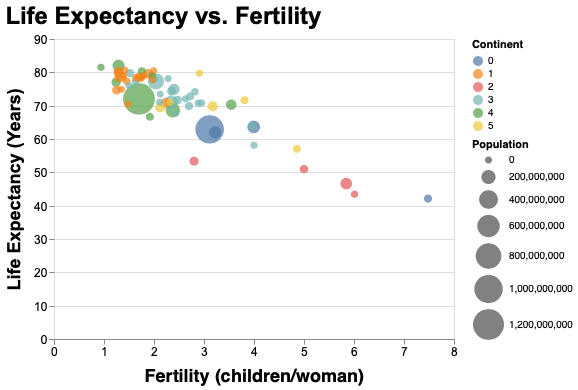

In [33]:
alt.Chart(data2000).mark_point(filled=True).encode(
    alt.X('fertility:Q', title="Fertility (children/woman)"),
    alt.Y('life_expect:Q',title="Life Expectancy (Years)"),
    alt.Size('pop:Q', scale=alt.Scale(range=[50,1000]), title="Population"),
    alt.Color('cluster:N',title="Continent"),
    alt.Order('pop:Q', sort='descending'),
    tooltip = [
        alt.Tooltip('country:N'),
        alt.Tooltip('fertility:Q'),
        alt.Tooltip('life_expect:Q') #another way to use altair tooltips
    ]   # important
).properties(width=400,height=300,title = "Life Expectancy vs. Fertility")

Now we can see multiple data fields upon mouse over!

### Column and Row Facets

Spatial position is one of the most powerful and flexible channels for visual encoding, but what can we do if we already have assigned fields to the `x` and `y` channels? One valuable technique is to create a *trellis plot*, consisting of sub-plots that show a subset of the data. A trellis plot is one example of the more general technique of presenting data using [small multiples](https://en.wikipedia.org/wiki/Small_multiple) of views.

The `column` and `row` encoding channels generate either a horizontal (columns) or vertical (rows) set of sub-plots, in which the data is partitioned according to the provided data field.

Here is a trellis plot that divides the data into one column per \`cluster\` value:

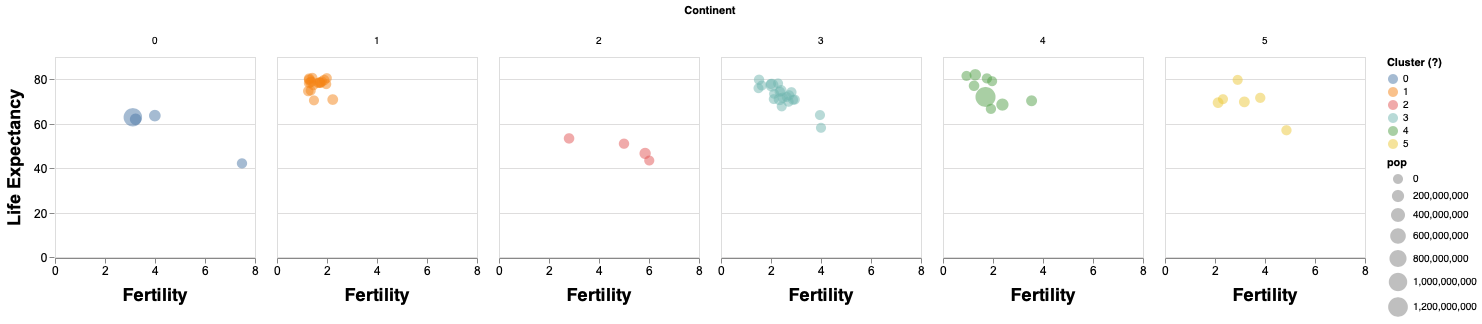

In [34]:
alt.Chart(data2000).mark_point(filled=True).encode(
    alt.X('fertility:Q', title="Fertility"),
    alt.Y('life_expect:Q', title="Life Expectancy"),
    alt.Size('pop:Q', scale=alt.Scale(range=[100,400])),
    alt.Color('cluster:N', title="Cluster (?)"),
    alt.OpacityValue(0.5),
    alt.Tooltip('country:N'),
    alt.Order('pop:Q', sort='descending'),
    alt.Column('cluster:N', title="Continent")
)

The plot above does not fit on screen, making it difficult to compare all the sub-plots to each other! We can set the default `width` and `height` properties to create a smaller set of multiples. Also, as the column headers already label the `cluster` values, let's remove our `color` legend by setting it to `None`. To make better use of space we can also orient our `size` legend to the `'bottom'` of the chart.

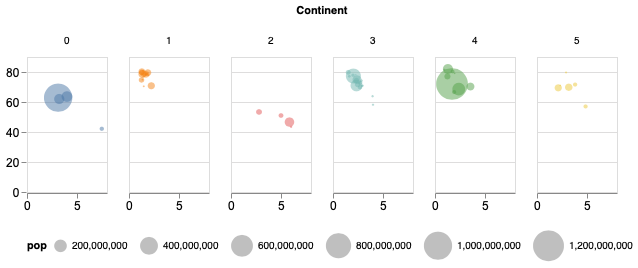

In [35]:
alt.Chart(data2000).mark_point(filled=True).encode(
    alt.X('fertility:Q'),
    alt.Y('life_expect:Q'),
    alt.Size('pop:Q', scale=alt.Scale(range=[0,1000]),
             legend=alt.Legend(orient='bottom', titleOrient='left')),
    alt.Color('cluster:N', legend=None),
    alt.OpacityValue(0.5),
    alt.Tooltip('country:N'),
    alt.Order('pop:Q', sort='descending'),
    alt.Column('cluster:N', title="Continent")
).properties(width=80, height=135)

Underneath the hood, the `column` and `row` encodings are translated into a new specification that uses the `facet` view composition operator. We will re-visit faceting in greater depth later on!

#### WQ05: Remake the chart above to facet into rows instead of columns.

In [36]:
# Your code here

### Bar Marks (and Histogram)

The \`bar\` mark type draws a rectangle with a position, width, and height.

The plot below is a histogram of the fertility of each country. Note the strange syntax of passing a function in as a string into Altair.

In [37]:
data2000.head()

,year,country,cluster,pop,life_expect,fertility
9,2000,Afghanistan,0,23898198,42.129,7.4792
20,2000,Argentina,3,37497728,74.340,2.3500
31,2000,Aruba,3,69539,73.451,2.1240
42,2000,Australia,4,19164620,80.370,1.7560
53,2000,Austria,1,8113413,78.980,1.3820


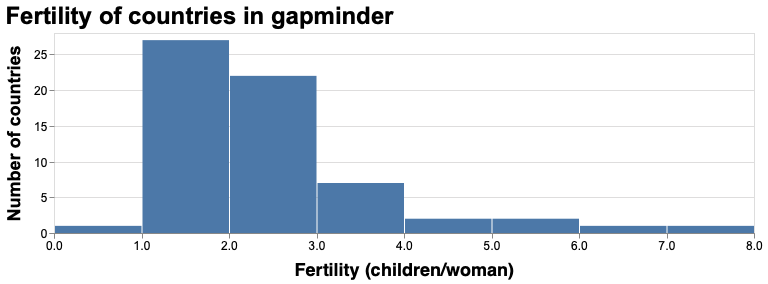

In [38]:
alt.Chart(data2000).mark_bar().encode(
    alt.X('fertility:Q', title="Fertility (children/woman)",bin=True),
    alt.Y('count()', title="Number of countries"),
).properties(width=700,title="Fertility of countries in gapminder")

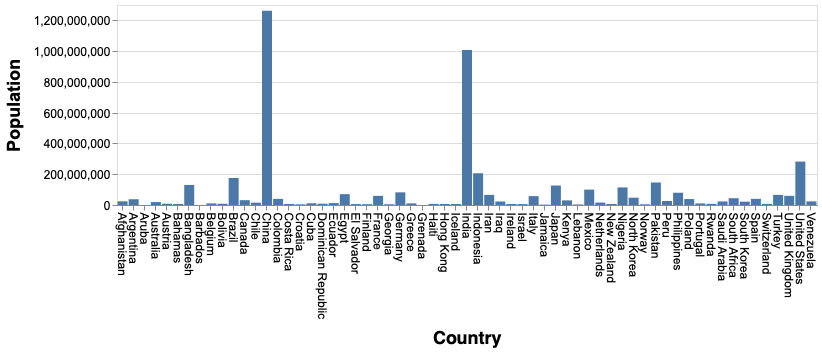

In [39]:
alt.Chart(data2000).mark_bar().encode(
    alt.X('country:N', title="Country"),
    alt.Y('pop:Q', title="Population"),
).properties(width=700).configure_axisX(labelAngle=90)

# This plot is terrible! What happened?

#Hint: add: ".configure_axisX(labelAngle=90)"

The bar width is set to a default size. To change the width, _try setting the \`rangeStep\` property of the \`x\` channel's \`scale\` attribute_. (In a later module we will take a closer look at configuring axes, scales, and legends.)

Bars can also be stacked. Let's change the `x` encoding to use the `cluster` field, and encode `country` using the `color` channel. We'll also disable the legend (which would be very long with colors for all countries!) and use tooltips for the country name.

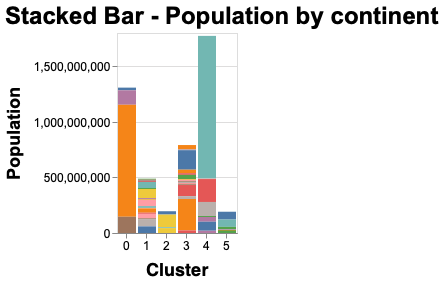

In [40]:
alt.Chart(data2000).mark_bar().encode(
    alt.X('cluster:N', title="Cluster"),
    alt.Y('pop:Q',title="Population"),
    alt.Color('country:N', legend=None),
    alt.Tooltip('country:N')
).properties(title="Stacked Bar - Population by continent")

In the chart above, the use of the `color` encoding channel causes Altair / Vega-Lite to automatically stack the bar marks. Otherwise, bars would be drawn on top of each other! Try adding the parameter `stack=None` to the `y` encoding channel to see what happens if we don't apply stacking...

The examples above create bar charts from a zero-baseline, and the `y` channel only encodes the non-zero value (or height) of the bar. However, the bar mark also allows you to specify starting and ending points to convey ranges.

The chart below uses the `x` (starting point) and `x2` (ending point) channels to show the range of life expectancies within each regional cluster. Below we use the `min` and `max` aggregation functions to determine the end points of the range; we will discuss aggregation in greater detail in the next notebook!

Alternatively, you can use `x` and `width` to provide a starting point plus offset, such that `x2 = x + width`.

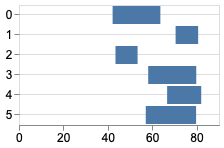

In [41]:
alt.Chart(data2000).mark_bar().encode(
    alt.X('min(life_expect):Q'),
    alt.X2('max(life_expect):Q'),
    alt.Y('cluster:N')
)

### Interactive Filtering

In later modules, we'll dive into interaction techniques for data exploration. Here is a sneak peak: binding a range slider to the `year` field to enable interactive scrubbing through each year of data. Don't worry if the code below is a bit confusing at this point, as we will cover interaction in detail later.

_Drag the slider back and forth to see how the data values change over time!_

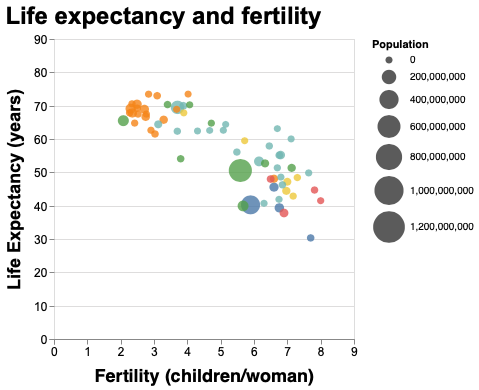

In [42]:
select_year = alt.selection_single(
    name='select', fields=['year'], init={'year': 1955},
    bind=alt.binding_range(min=1955, max=2005, step=5)
)

alt.Chart(data).mark_point(filled=True).encode(
    alt.X('fertility:Q', scale=alt.Scale(domain=[0,9]), title="Fertility (children/woman)"),
    alt.Y('life_expect:Q', scale=alt.Scale(domain=[0,90]), title="Life Expectancy (years)"),
    alt.Size('pop:Q', scale=alt.Scale(domain=[0, 1200000000], range=[50,1000]), title="Population"),
    alt.Color('cluster:N', title="Continent", legend=None),
    alt.OpacityValue(0.8),
    alt.Tooltip('country:N'),
    alt.Order('pop:Q', sort='descending')
).add_selection(select_year).transform_filter(select_year
).properties(width=300,height=300, title="Life expectancy and fertility")

### Area Marks

The `area` mark type combines aspects of `line` and `bar` marks: it visualizes connections (slopes) among data points, but also shows a filled region, with one edge defaulting to a zero-valued baseline.

The chart below is an area chart of population over time for just the United States:

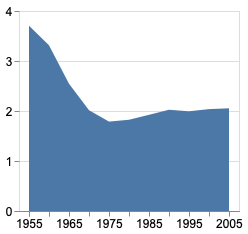

In [43]:
dataUS = data.loc[data['country'] == 'United States']

# Add x,y labels and title to this plot

alt.Chart(dataUS).mark_area().encode(
    alt.X('year:O'),
    alt.Y('fertility:Q')
)

Similar to `line` marks, `area` marks support an `interpolate` parameter.

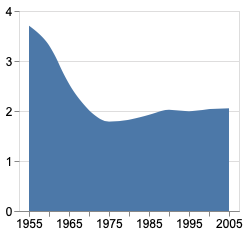

In [44]:
# Add x,y labels and title to this plot

alt.Chart(dataUS).mark_area(interpolate='monotone').encode(
    alt.X('year:O'),
    alt.Y('fertility:Q')
)

Similar to `bar` marks, `area` marks also support stacking. Here we create a new data frame with data for the three North American countries, then plot them using an `area` mark and a `color` encoding channel to stack by country.

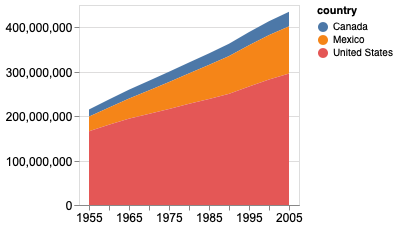

In [45]:
# Add x,y labels and title to this plot

dataNA = data.loc[
    (data['country'] == 'United States') |
    (data['country'] == 'Canada') |
    (data['country'] == 'Mexico')
]

alt.Chart(dataNA).mark_area().encode(
    alt.X('year:O'),
    alt.Y('pop:Q'),
    alt.Color('country:N')
)

By default, stacking is performed relative to a zero baseline. However, other `stack` options are available:

* `center` - to stack relative to a baseline in the center of the chart, creating a *streamgraph* visualization, and
* `normalize` - to normalize the summed data at each stacking point to 100%, enabling percentage comparisons.

Below we adapt the chart by setting the `y` encoding `stack` attribute to `center`. What happens if you instead set it `normalize`?

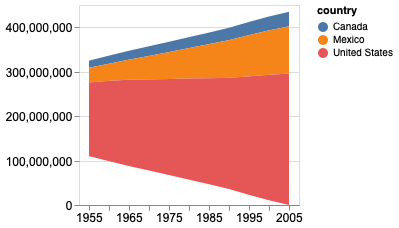

In [46]:
# Add x,y labels and title to this plot

alt.Chart(dataNA).mark_area().encode(
    alt.X('year:O'),
    alt.Y('pop:Q', stack='center'),
    alt.Color('country:N')
)

To disable stacking altogether, set the  `stack` attribute to `None`. We can also add `opacity` as a default mark parameter to ensure we see the overlapping areas!

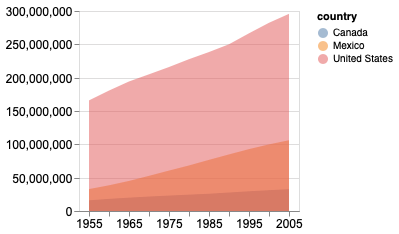

In [47]:
# Add x,y labels and title to this plot

alt.Chart(dataNA).mark_area(opacity=0.5).encode(
    alt.X('year:O'),
    alt.Y('pop:Q', stack=None),
    alt.Color('country:N')
)

The `area` mark type also supports data-driven baselines, with both the upper and lower series determined by data fields. As with `bar` marks, we can use the `x` and `x2` (or `y` and `y2`) channels to provide end points for the area mark.

The chart below visualizes the range of minimum and maximum fertility, per year, for North American countries:

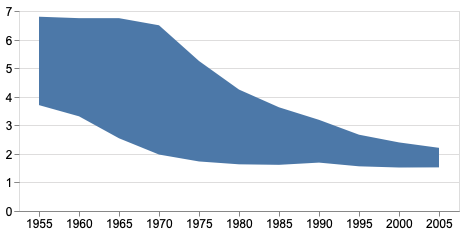

In [48]:
# Add x,y labels and title to this plot

alt.Chart(dataNA).mark_area().encode(
    alt.X('year:O', scale=alt.Scale(rangeStep=40)),
    alt.Y('min(fertility):Q'),
    alt.Y2('max(fertility):Q')
)

We can see a larger range of values in 1995, from just under 4 to just under 7. By 2005, both the overall fertility values and the variability have declined, centered around 2 children per familty.

All the `area` mark examples above use a vertically oriented area. However, Altair and Vega-Lite support horizontal areas as well. Let's transpose the chart above, simply by swapping the `x` and `y` channels.

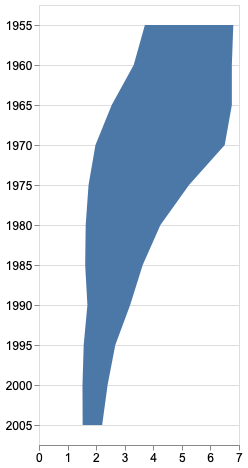

In [49]:
# Add x,y labels and title to this plot

alt.Chart(dataNA).mark_area().encode(
    alt.Y('year:O', scale=alt.Scale(rangeStep=40)),
    alt.X('min(fertility):Q'),
    alt.X2('max(fertility):Q')
)

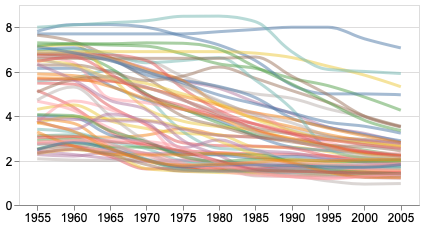

In [54]:
alt.Chart(data).mark_line(
    strokeWidth=3,
    opacity=0.5,
    interpolate='monotone'
).encode(
    alt.X('year:O'),
    alt.Y('fertility:Q'),
    alt.Color('country:N', legend=None),
    alt.Tooltip('country:N')
).properties(
    width=400
)